In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_log_error, make_scorer, mean_absolute_error, r2_score


import sklearn
sklearn.set_config(transform_output="pandas")
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split

## Шаг 1: Загрузка датасетов

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## Шаг 2: Логорифмирования таргета и инициализацция x_train, y_train

In [4]:
x_train, y_train = train.drop('SalePrice',axis=1), np.log(train['SalePrice'])

## Шаг 3: Обьединение обучающей и тестовой выборки в единый датафрейм, начало сбора Pipeline

In [5]:
pd.set_option('display.max_columns', None)  # Отображение всех колонок

pd.set_option('display.expand_frame_repr', False)

In [5]:
df_merged = pd.concat([train, test], axis=0, ignore_index=True)
df_merged

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
2915,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
2916,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN
2917,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,NaN


### 3.1: Сбор Pipeline

In [6]:
columns_to_drop = ['Alley', 'PoolQC', 'Fence', 'MiscFeature', 'Id']
my_imputer = ColumnTransformer(
    transformers = [
        ('drop_features', 'drop', columns_to_drop),
        ('cat_imputer', SimpleImputer(strategy='most_frequent'), ['LotFrontage', 'Electrical', 'MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'KitchenQual', 'Functional', 'GarageCars', 'SaleType']),
        ('num_imputer_0', SimpleImputer(strategy='constant', fill_value='0'), ['MasVnrType', 'BsmtUnfSF' ,'BsmtQual', 'MasVnrArea', 'BsmtExposure', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']),
        ('num_imputer_mean', SimpleImputer(strategy='mean'), ['BsmtFinSF2','BsmtFinSF1', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageArea'])
    ],
    verbose_feature_names_out=False,
    remainder='passthrough'
)

# категориальный колонки 
cat_columns = [
    'MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual','GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition'
]  
# численныые колонки за вычетом SalePrice для нормализации
num_columns = [
       'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold'
       ] 
# колонки для ordinal_encoding только с двумя вариантами данных 
ordinal_encoding_columns = [
    'Street', 'Utilities', 'CentralAir'
] 
one_hot_encoding_columns = [col for col in cat_columns if col not in ordinal_encoding_columns] # колонки для one_hot_encoding


scaler_and_encoder = ColumnTransformer(
    transformers=[
        ('original encoding', OrdinalEncoder(), ordinal_encoding_columns),
        ('one_hot_encoding', OneHotEncoder(sparse_output=False), one_hot_encoding_columns),
        ('scaling', StandardScaler(), num_columns)
    ],
    verbose_feature_names_out=False, 
    remainder= 'passthrough' 
)

# учет удаляемых колонок на основе Lasso и Importance_Features
columns_to_drop_after_scaler_encoder = ['Condition1_RRNe',
 'Condition2_Artery',
 'GarageCond_Fa',
 'Heating_Floor',
 'BsmtCond_TA',
 'Exterior2nd_Other',
 'RoofMatl_Metal',
 'Condition2_RRNn',
 'GarageFinish_Fin',
 'ExterCond_Po',
 'HouseStyle_SFoyer',
 'Utilities',
 'RoofMatl_WdShake',
 'Foundation_Wood',
 'KitchenQual_TA',
 'Condition2_PosN',
 'GarageQual_Po',
 'RoofMatl_Membran',
 'Neighborhood_NPkVill',
 'HouseStyle_2.5Fin',
 'ExterQual_TA',
 'GarageQual_0',
 'PavedDrive_Y',
 'Exterior1st_CBlock',
 'BsmtExposure_0',
 'RoofMatl_Roll',
 'Neighborhood_SWISU',
 'BsmtFinType2_Rec',
 'GarageCond_Ex',
 'LotConfig_Inside',
 'SaleType_Oth',
 'SaleType_Con',
 'Exterior1st_Stone',
 'Condition2_RRAn',
 'GarageCond_0',
 'Electrical_Mix',
 'Exterior2nd_CBlock',
 'Street',
 'Condition2_PosA',
 'GarageQual_Gd',
 'BsmtCond_Po',
 'Condition2_RRAe',
 'SaleType_ConLI']
after_dropper = ColumnTransformer(
    transformers=[
        ('after_dropper', 'drop', columns_to_drop_after_scaler_encoder)
    ],
    verbose_feature_names_out=False, 
    remainder= 'passthrough' 
)

preprocessor = Pipeline(
    [
        ('imputer_and_dropper', my_imputer),
        ('scaler_and_encoder', scaler_and_encoder),
        ('after_dropper', after_dropper)
    ]
)

In [7]:
x = preprocessor.fit_transform(df_merged) # подготовленные данные для ML

## Шаг 4: Разьединение выборок обратно

In [8]:
train_ml_ready, test_ml_ready = x[x['SalePrice'].notna()], (x[x['SalePrice'].isna()]) # разделение датасетов на train и test по колонке SalePrice

In [9]:
test_ml_ready = test_ml_ready.drop('SalePrice', axis=1)


In [10]:
x_train, y_train = train_ml_ready.drop('SalePrice', axis=1), train_ml_ready['SalePrice'] # разделение на фитчи и таргет
x_train_split, x_val, y_train_split, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

## Шаг 5 Нахождение оптимальных параметров для моделей LightGBM, XGBoost, RandomForest, Voting и CatBoost

#### LightGBM

In [11]:
import logging

logging.getLogger("lightgbm").setLevel(logging.CRITICAL)
logging.getLogger("optuna").setLevel(logging.CRITICAL)

def objective_lgbm(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=50),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "num_leaves": trial.suggest_int("num_leaves", 7, 127),
    }
    model = LGBMRegressor(**params, random_state=42)
    model.fit(x_train_split, y_train_split)
    predict = model.predict(x_val)
    score = np.sqrt(mean_squared_log_error(y_val, predict))
    return score 

study_lgbm = optuna.create_study(direction="minimize")  # Минимизация RMSLE
study_lgbm.optimize(objective_lgbm, n_trials=50)

print("Best LGBM Parameters:", study_lgbm.best_params)
print("Best LGBM RMSLE Score:", study_lgbm.best_value)



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3188
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 170
[LightGBM] [Info] Start training from score 181441.541952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [38]:
ml_lgb = LGBMRegressor(n_estimators=750, learning_rate=0.037838631564188145, max_depth=4, num_leaves=7)
ml_lgb.fit(x_train_split, y_train_split)

y_pred_lgb = ml_lgb.predict(x_val)

r2_lgb = r2_score(y_val, y_pred_lgb)
mae_lgb = mean_absolute_error(y_val, y_pred_lgb)
rsmle_lgb = np.sqrt(mean_squared_log_error(y_val, y_pred_lgb))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3188
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 170
[LightGBM] [Info] Start training from score 181441.541952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

#### XGBoost

In [13]:
import logging

logging.getLogger("xgboost").setLevel(logging.CRITICAL)
logging.getLogger("optuna").setLevel(logging.CRITICAL)

def objective_xgb(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=50),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 15)
    }
    model = XGBRegressor(**params, random_state=42)
    model.fit(x_train_split, y_train_split)
    predict = model.predict(x_val)
    score = np.sqrt(mean_squared_log_error(y_val, predict))
    return score 


study_xgb = optuna.create_study(direction="minimize")  # Минимизация RMSLE
study_xgb.optimize(objective_xgb, n_trials=50)

print("Best XGB Parameters:", study_xgb.best_params)
print("Best XGB RMSLE Score:", study_xgb.best_value)

Best XGB Parameters: {'n_estimators': 550, 'learning_rate': 0.04559922091287099, 'max_depth': 4}
Best XGB RMSLE Score: 0.12387645214321104


In [85]:
from sklearn import set_config
set_config(display='text')

In [41]:
ml_xgb = XGBRegressor(n_estimators=550, learning_rate=0.04559922091287099, max_depth=4)
ml_xgb.fit(x_train_split, y_train_split)

y_pred_xgb = ml_xgb.predict(x_val)

r2_xgb = r2_score(y_val, y_pred_xgb)
mae_xgb = mean_absolute_error(y_val, y_pred_xgb)
rsmle_xgb = np.sqrt(mean_squared_log_error(y_val, y_pred_xgb))

#### RandomForest

In [16]:
import logging

logging.getLogger("randomforest").setLevel(logging.CRITICAL)
logging.getLogger("optuna").setLevel(logging.CRITICAL)

def objective_rf(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=50),
        "max_depth": trial.suggest_int("max_depth", 3, 15)
    }
    model = RandomForestRegressor(**params, random_state=42)
    model.fit(x_train_split, y_train_split)
    predict = model.predict(x_val)
    score = np.sqrt(mean_squared_log_error(y_val, predict))
    return score 


study_rf = optuna.create_study(direction="minimize")  # Минимизация RMSLE
study_rf.optimize(objective_rf, n_trials=50)

print("Best RandomForest Parameters:", study_rf.best_params)
print("Best RandomForest RMSLE Score:", study_rf.best_value)

Best RandomForest Parameters: {'n_estimators': 850, 'max_depth': 14}
Best RandomForest RMSLE Score: 0.15143598346350065


In [42]:
ml_rf = RandomForestRegressor(n_estimators=850, max_depth=14)
ml_rf.fit(x_train_split, y_train_split)

y_pred_rf = ml_rf.predict(x_val)

r2_rf = r2_score(y_val, y_pred_rf)
mae_rf = mean_absolute_error(y_val, y_pred_rf)
rsmle_rf = np.sqrt(mean_squared_log_error(y_val, y_pred_rf))

#### Voting

In [18]:
import logging

logging.getLogger("voting").setLevel(logging.CRITICAL)
logging.getLogger("optuna").setLevel(logging.CRITICAL)

def objective_vt(trial):
    neighbors = trial.suggest_int('n_neighbors', 3, 20)
    depth = trial.suggest_int("max_depth", 3, 15)
    n_features = trial.suggest_int('max_features', 1, 100)
    samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    model = VotingRegressor([
        ('linreg', LinearRegression()),
        ('kneibors', KNeighborsRegressor(n_neighbors=neighbors)),
        ('decisiontree', DecisionTreeRegressor(max_depth=depth, max_features=n_features, min_samples_leaf=samples_leaf))
    ])
    model.fit(x_train_split, y_train_split)
    predict = model.predict(x_val)
    score = np.sqrt(mean_squared_log_error(y_val, predict))
    return score 


study_vt = optuna.create_study(direction="minimize")  # Минимизация RMSLE
study_vt.optimize(objective_vt, n_trials=50)

print("Best Voting Parameters:", study_vt.best_params)
print("Best Voting RMSLE Score:", study_vt.best_value)

Best Voting Parameters: {'n_neighbors': 13, 'max_depth': 12, 'max_features': 76, 'min_samples_leaf': 7}
Best Voting RMSLE Score: 0.14167147732597818


In [43]:
ml_vt = LGBMRegressor(n_neighbors=13, max_depth=12, max_features=76, min_samples_leaf=7)
ml_vt.fit(x_train_split, y_train_split)

y_pred_vt = ml_vt.predict(x_val)

r2_vt = r2_score(y_val, y_pred_vt)
mae_vt = mean_absolute_error(y_val, y_pred_vt)
rsmle_vt = np.sqrt(mean_squared_log_error(y_val, y_pred_vt))

[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: n_neighbors
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=7. Current value: min_data_in_leaf=7
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: n_neighbors
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=7. Current value: min_data_in_leaf=7
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3262
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 207
[LightGBM] [Info] Start training from score 181441.541952
[Li

#### CatBoost

In [24]:
import logging

logging.getLogger('catboost').setLevel(logging.CRITICAL)
logging.getLogger('optuna').setLevel(logging.CRITICAL)


def object_cat(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=50),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
    }
    catboost_model = CatBoostRegressor(eval_metric='RMSE', random_seed=42, silent=True, **params)
    catboost_model.fit(x_train_split, y_train_split)
    cat_predict = catboost_model.predict(x_val)
    score = np.sqrt(mean_squared_log_error(y_val, cat_predict))
    return score

study_catboost = optuna.create_study(direction="minimize")
study_catboost.optimize(object_cat, n_trials=50)


print("Best parameters: ", study_catboost.best_params)
print("Best RMSLE: ", study_catboost.best_value)

Best parameters:  {'n_estimators': 350, 'learning_rate': 0.12667734275639075, 'max_depth': 5}
Best RMSLE:  0.12718385278500133


In [ ]:
ml_cb = CatBoostRegressor(n_estimators=350, learning_rate=0.12667734275639075, max_depth=5)
ml_cb.fit(x_train_split, y_train_split)


y_pred_cb = ml_cb.predict(x_val)


r2_cb = r2_score(y_val, y_pred_cb)  
mae_cb = mean_absolute_error(y_val, y_pred_cb)  
rsmle_cb = np.sqrt(mean_squared_log_error(y_val, y_pred_cb))  

0:	learn: 70896.7095841	total: 2.01ms	remaining: 701ms
1:	learn: 65628.3417511	total: 4.04ms	remaining: 703ms
2:	learn: 60974.9064072	total: 5.91ms	remaining: 683ms
3:	learn: 56689.8716294	total: 8.2ms	remaining: 709ms
4:	learn: 52911.9114856	total: 10ms	remaining: 691ms
5:	learn: 49599.1093144	total: 11.7ms	remaining: 671ms
6:	learn: 46978.3548214	total: 13.1ms	remaining: 640ms
7:	learn: 44737.2665251	total: 14.7ms	remaining: 627ms
8:	learn: 42766.5617529	total: 16.2ms	remaining: 615ms
9:	learn: 40930.8890983	total: 18.7ms	remaining: 636ms
10:	learn: 39114.6015487	total: 20.3ms	remaining: 625ms
11:	learn: 37480.6096535	total: 21.6ms	remaining: 609ms
12:	learn: 35981.6064363	total: 24.6ms	remaining: 637ms
13:	learn: 34800.3035878	total: 26ms	remaining: 623ms
14:	learn: 33705.7569544	total: 27.3ms	remaining: 610ms
15:	learn: 32528.6986313	total: 28.6ms	remaining: 598ms
16:	learn: 31545.0841847	total: 29.9ms	remaining: 585ms
17:	learn: 30650.7943599	total: 31.2ms	remaining: 575ms
18:	lea

## Шаг 6: Предикт таргета для test_ml_ready

Создание predictions и сохранение в правильном формате submission.csv

In [49]:
predictions = ml_xgb.predict(test_ml_ready)
submission = pd.DataFrame({
    "Id": test['Id'],
    "SalePrice": predictions
})
submission.to_csv("submission1.csv", index=False)

## Результаты после загрузки на Kaggle

In [47]:
import matplotlib.image as mpimg
img = mpimg.imread('/Users/Mashulik/Desktop/kaggle.png')
plt.figure(figsize=(20,6))
plt.imshow(img)
plt.axis('off');

FileNotFoundError: [Errno 2] No such file or directory: '/Users/Mashulik/Desktop/kaggle.png'

#### Сводная таблица метрик

In [45]:
metrics_df = pd.DataFrame(data={
    'rmsle': [rsmle_cb, rsmle_lgb, rsmle_rf, rsmle_vt, rsmle_xgb],
    'r2-score':[r2_cb, r2_lgb, r2_rf, r2_vt, r2_xgb],
    'mae':[mae_cb, mae_lgb, mae_rf, mae_vt, mae_xgb]
}, index=['CatBoost', 'LightGBM', 'RandomForestRegressor', 'VotingRegressor', 'XGBoost'])

In [46]:
metrics_df

,rmsle,r2-score,mae
CatBoost,0.136045,0.915128,15462.332802
LightGBM,0.135103,0.892099,16723.571509
RandomForestRegressor,0.151967,0.888833,17466.302192
VotingRegressor,0.137934,0.902673,16322.919371
XGBoost,0.123876,0.924127,14868.976228


In [57]:
metrics_df.to_csv('metrics.csv')

In [59]:
import shap
shap.initjs()
ml_xgb = XGBRegressor(n_estimators=550, learning_rate=0.04559922091287099, max_depth=4)
ml_xgb.fit(x_train_split, y_train_split)


explainer = shap.TreeExplainer(ml_xgb)
shap_values = explainer.shap_values(x_train)


shap.force_plot(explainer.expected_value, shap_values[0,:], x_train.iloc[0,:])

In [ ]:
cor_matr = train[numeric_features]
plt.figure(figsize=(20,20))
sns.heatmap(cor_matr.corr(), annot=True, fmt='.2f')

In [56]:
tr = y_train.mean()
tr

180921.19589041095

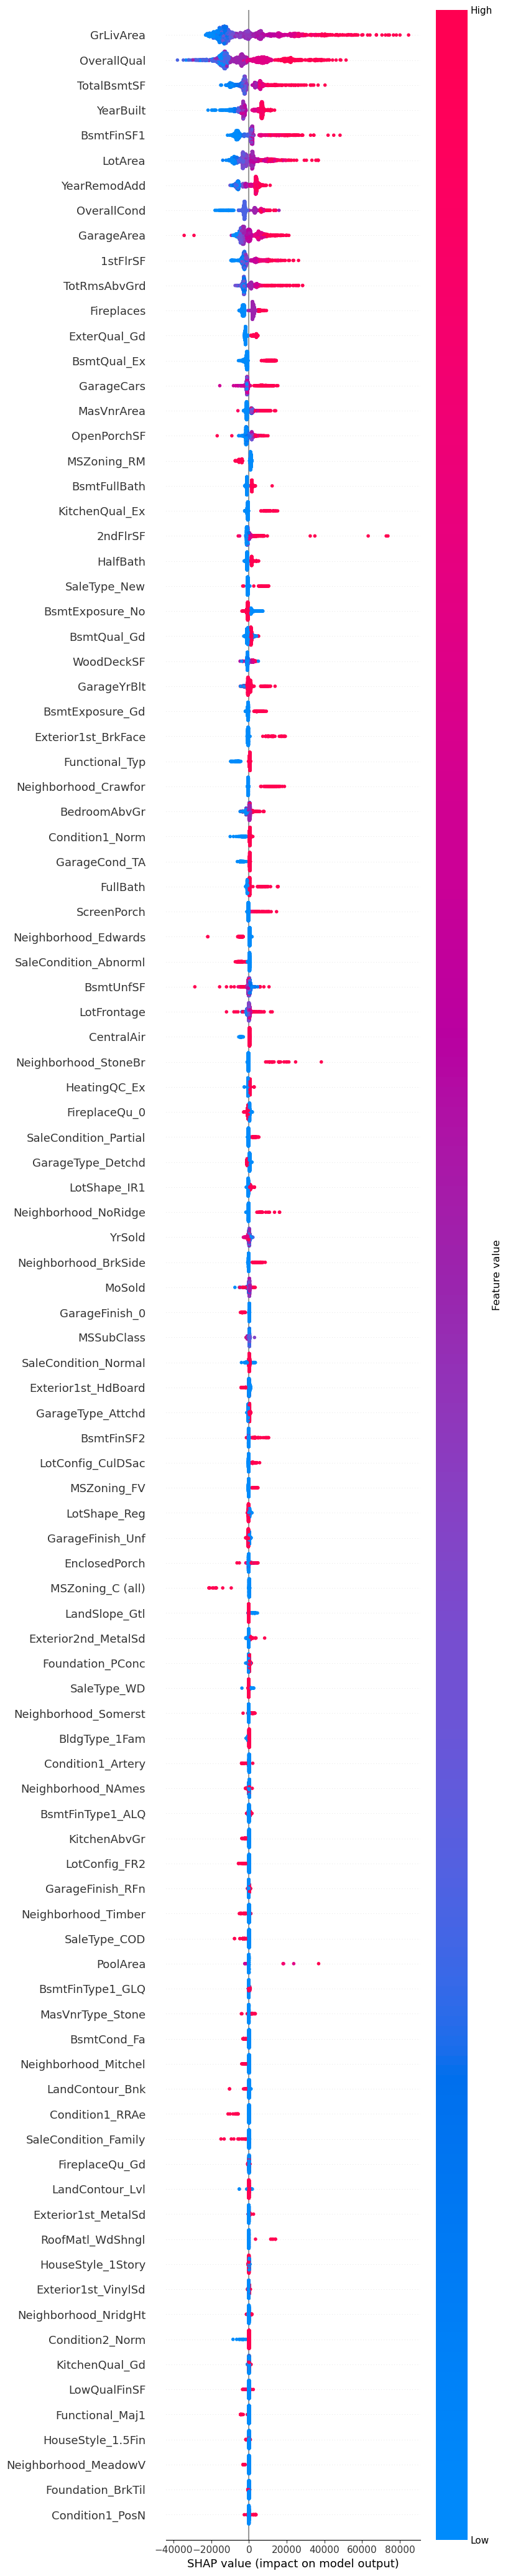

In [52]:
shap.summary_plot(shap_values, x_train, max_display=100)